In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# For producing decision tree diagrams.
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from sklearn.datasets import load_iris

/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_74545/218255412.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


# First I followed Faye's cleaning process

I did this for practice, but also to do some EDA at the bottom where I needed to reference a feature we ended up dropping from our models. I combined rural and urban population to create a total population feature for a plot that compares average CO2 emissions against global total regional population.

In [17]:
ag_data=pd.read_csv('Agrofood_co2_emission.csv')
print(ag_data.columns.tolist())

['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues', 'Rice Cultivation', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Food Transport', 'Forestland', 'Net Forest conversion', 'Food Household Consumption', 'Food Retail', 'On-farm Electricity Use', 'Food Packaging', 'Agrifood Systems Waste Disposal', 'Food Processing', 'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils', 'Manure left on Pasture', 'Manure Management', 'Fires in organic soils', 'Fires in humid tropical forests', 'On-farm energy use', 'Rural population', 'Urban population', 'Total Population - Male', 'Total Population - Female', 'total_emission', 'Average Temperature °C']


In [18]:
ag_data.columns = ag_data.columns.str.replace(' -', '')
ag_data.columns = ag_data.columns.str.replace('\(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace('\)', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = map(str.lower, ag_data.columns)

print(ag_data.columns.tolist())

['area', 'year', 'savanna_fires', 'forest_fires', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'pesticides_manufacturing', 'food_transport', 'forestland', 'net_forest_conversion', 'food_household_consumption', 'food_retail', 'on-farm_electricity_use', 'food_packaging', 'agrifood_systems_waste_disposal', 'food_processing', 'fertilizers_manufacturing', 'ippu', 'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests', 'on-farm_energy_use', 'rural_population', 'urban_population', 'total_population_male', 'total_population_female', 'total_emission', 'average_temperature_°c']


In [19]:
ag_data = ag_data.drop(['total_population_female', 'total_population_male'], axis=1)
print(ag_data.columns.tolist())

['area', 'year', 'savanna_fires', 'forest_fires', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'pesticides_manufacturing', 'food_transport', 'forestland', 'net_forest_conversion', 'food_household_consumption', 'food_retail', 'on-farm_electricity_use', 'food_packaging', 'agrifood_systems_waste_disposal', 'food_processing', 'fertilizers_manufacturing', 'ippu', 'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests', 'on-farm_energy_use', 'rural_population', 'urban_population', 'total_emission', 'average_temperature_°c']


In [20]:
ag_data['fires'] = ag_data['savanna_fires']+ag_data['forest_fires']+ag_data['fires_in_organic_soils']+ag_data['fires_in_humid_tropical_forests']
ag_data['manure_mgmt'] = ag_data['manure_applied_to_soils']+ag_data['manure_left_on_pasture']+ag_data['manure_management']
ag_data['food_systems'] = ag_data['food_processing']+ag_data['food_packaging']+ag_data['food_retail']+ag_data['food_transport']+ag_data['food_household_consumption']+ag_data['agrifood_systems_waste_disposal']
ag_data['ippu_tot'] = ag_data['ippu']+ag_data['pesticides_manufacturing']+ag_data['fertilizers_manufacturing']
ag_data['on_farm_energy_use'] = ag_data['on-farm_electricity_use'] + ag_data['on-farm_energy_use']
ag_data['total_population'] = ag_data['rural_population']+ag_data['urban_population']

ag_data = ag_data.drop(['savanna_fires', 'forest_fires', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests',
                       'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'food_processing',
                       'food_packaging', 'food_retail', 'food_transport', 'food_household_consumption',
                       'agrifood_systems_waste_disposal', 'ippu', 'pesticides_manufacturing', 'fertilizers_manufacturing',
                       'on-farm_electricity_use', 'on-farm_energy_use'], axis=1)

print(ag_data.columns.tolist())

['area', 'year', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion', 'rural_population', 'urban_population', 'total_emission', 'average_temperature_°c', 'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_population']


In [21]:
enso_data = pd.read_csv('meiv2.csv')
enso_data.columns = map(str.lower, enso_data.columns)

#Drop years before 1990 and after 2020
enso_data = enso_data[enso_data['year'] <= 2020]
enso_data = enso_data[enso_data['year'] > 1989]

enso_data = enso_data.set_index('year')

#Calculate yearly average index
enso_data['mei'] = enso_data.mean(axis=1)

#Reset index
enso_data = enso_data.reset_index(names=['year'])

#Drop months columns
enso_data = enso_data.drop(["dj",'jf','fm','ma','am','mj','jj','ja','as','so','on','nd'], axis='columns')

In [22]:
ag_data = ag_data.merge(enso_data, left_on='year', right_on='year')

In [24]:
region_data = pd.read_csv('continents.csv')

In [25]:
region_data = region_data.drop(['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2','intermediate-region', 
                                'region-code', 'sub-region-code','intermediate-region-code'], axis=1)

In [26]:
ag_data = ag_data.merge(region_data, left_on='area', right_on='name', how='left').drop(['name'], axis=1)

In [27]:
def update_regions():

    asia_region = ['China, Hong Kong SAR',
                    'China, Macao SAR',
                    'China, Taiwan Province of',
                    'China, mainland',
                    "Democratic People's Republic of Korea",
                    'Republic of Korea']
    
    for area in asia_region:
        ag_data.loc[ag_data['area']==area,'region']='Asia'
        ag_data.loc[ag_data['area']==area,'sub-region']='Eastern Asia'

    
    # 'British Virgin Islands' # Americas, Latin America and the Caribbean 
    # 'United States Virgin Islands' # Americas, Latin America and the Caribbean
    americas_region = ['British Virgin Islands', 'United States Virgin Islands']    
    
    for area in americas_region:
        ag_data.loc[ag_data['area']==area,'region']='Americas'
        ag_data.loc[ag_data['area']==area,'sub-region']='Latin America and the Caribbean'
    
    #'Palestine' # Asia, Western Asia
    ag_data.loc[ag_data['area']=='Palestine','region']='Asia'
    ag_data.loc[ag_data['area']=='Palestine','sub-region']='Western Asia'

    # 'Wallis and Futuna Islands' # Oceania, Polynesia
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','region']='Oceania'
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','sub-region']='Polynesia'

    # 'Republic of Moldova' # Europe, Eastern Europe
    # 'Serbia and Montenegro' # Europe, Southern Europe
    # 'Channel Islands' # Europe, Northern Europe
    # 'Netherlands (Kingdom of the)' # Europe, Western Europe
    # 'Belgium-Luxembourg' # Europe, Western Europe
    europe_region = ['Republic of Moldova',
                     'Serbia and Montenegro',
                     'Channel Islands',
                     'Netherlands (Kingdom of the)',
                     'Belgium-Luxembourg']
    for area in europe_region:
        ag_data.loc[ag_data['area']==area,'region']='Europe'
        ag_data.loc[ag_data['area']==area,'sub-region']='Western Europe'

    ag_data.loc[ag_data['area']=='Republic of Moldova','sub-region']='Eastern Europe'
    ag_data.loc[ag_data['area']=='Serbia and Montenegro','sub-region']='Southern Europe'
    ag_data.loc[ag_data['area']=='Channel Islands','sub-region']='Northern Europe'
    

    # 'Ethiopia PDR' # Afria, Sub-Saharan Africa
    # 'United Republic of Tanzania' # Afria, Sub-Saharan Africa
    # 'Democratic Republic of the Congo' # Africa, Sub-Saharan Africa
    africa_region = ['Ethiopia PDR', 'United Republic of Tanzania', 'Democratic Republic of the Congo']

    for area in africa_region:
        ag_data.loc[ag_data['area']==area,'region']='Africa'
        ag_data.loc[ag_data['area']==area,'sub-region']='Sub-Saharan Africa'


update_regions()

In [30]:
ag_data = ag_data[ag_data['area'] != 'Belgium-Luxembourg']

In [31]:
ag_data = ag_data[ag_data['area'] != 'Czechoslovakia']

In [32]:
ag_data = ag_data[ag_data['area'] != 'USSR']

In [33]:
ag_data = ag_data[ag_data['area'] != 'Yugoslav SFR']

In [34]:
ag_data = ag_data[ag_data['area'] != 'Pacific Islands Trust Territory']

In [35]:
ag_data.loc[ag_data["area"] == "Ethiopia PDR", 'area'] = "Ethiopia"


In [36]:
ag_data = ag_data[ag_data['area'] != 'Serbia']
ag_data = ag_data[ag_data['area'] != 'Montenegro']
ag_data = ag_data[ag_data['area'] != 'Serbia and Montenegro']

In [37]:
ag_data = ag_data[ag_data['area'] != 'Sudan (former)']
ag_data = ag_data[ag_data['area'] != 'Sudan']
ag_data = ag_data[ag_data['area'] != 'South Sudan']

In [38]:
ag_data = ag_data[ag_data['area'] != 'Netherlands Antilles (former)']

In [39]:
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

Series([], Name: year, dtype: int64)

In [40]:
ag_data['area'].nunique()

223

In [93]:
#define an array with the unique year values
years_count_missing = dict.fromkeys(ag_data['year'].unique(), 0)
for ind, row in ag_data.iterrows():
    years_count_missing[row['year']] += row.isnull().sum()

# sort the years by missing values
years_missing_sorted = dict(sorted(years_count_missing.items(), key=lambda item: item[1]))


In [92]:
# define an array with the unique country values
areas_count_missing = dict.fromkeys(ag_data['area'].unique(), 0)

# iterate through all rows and count the amount of NaN values for each country
for ind, row in ag_data.iterrows():
    areas_count_missing[row['area']] += row.isnull().sum()

# sort the countries by missing values
areas_missing_sorted = dict(sorted(areas_count_missing.items(), key=lambda item: item[1]))

In [43]:
areas_null_count = ag_data.groupby(['area']).apply(lambda x: x.isnull().sum())
areas_null_count['total_null']=areas_null_count.sum(axis=1)
included_areas = areas_null_count.area[areas_null_count['total_null']<63].index
# filter ag_data for included areas only
ag_data = ag_data[ag_data['area'].isin(included_areas)]

In [44]:
ag_data.isnull().sum()

area                           0
year                           0
crop_residues                435
rice_cultivation               0
drained_organic_soils_co2      0
forestland                   122
net_forest_conversion        122
rural_population               0
urban_population               0
total_emission                 0
average_temperature_°c         0
fires                          0
manure_mgmt                  158
food_systems                 132
ippu_tot                     124
on_farm_energy_use           606
total_population               0
mei                            0
region                         0
sub-region                     0
dtype: int64

In [45]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,rural_population,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,total_population,mei,region,sub-region
area,,,,,,,,,,,,,,,,,,,
Andorra,62155,0.0,28716.610633,0.0000,0.0000,0.0000,213421.0,2038525.0,163914.151678,39.800000,0.0000,0.0000,8542.204360,53007.193557,2340.875946,2251946.0,-2.058333,EuropeEuropeEuropeEuropeEuropeEuropeEuropeEuro...,Southern EuropeSouthern EuropeSouthern EuropeS...
Aruba,62155,0.0,60320.883163,0.0000,-1.7989,0.0000,1583298.0,1311424.0,205325.247943,24.766342,0.0000,0.0000,22373.504275,50012.139891,887.887100,2894722.0,-2.058333,AmericasAmericasAmericasAmericasAmericasAmeric...,Latin America and the CaribbeanLatin America a...
Bahrain,4025,0.0,1515.513286,0.0000,-5.1600,0.0000,281117.0,2305816.0,14630.473086,3.334500,0.0000,66.1694,5475.665800,7499.039600,0.000000,2586933.0,-0.683333,AsiaAsia,Western AsiaWestern Asia
Cook Islands,62155,0.0,28840.927293,0.0000,-298.8975,0.0000,182531.0,389220.0,80561.005195,7.669833,0.0000,455.1356,0.000000,33187.644291,141.007200,571751.0,-2.058333,OceaniaOceaniaOceaniaOceaniaOceaniaOceaniaOcea...,PolynesiaPolynesiaPolynesiaPolynesiaPolynesiaP...
Equatorial Guinea,62155,0.0,25615.721335,1.3162,-63030.9163,181798.1238,9970045.0,15478753.0,231010.733962,22.450683,13.4529,281.9080,14110.303996,70548.273031,1672.551000,25448798.0,-2.058333,AfricaAfricaAfricaAfricaAfricaAfricaAfricaAfri...,Sub-Saharan AfricaSub-Saharan AfricaSub-Sahara...
Marshall Islands,60165,0.0,60831.997342,0.0000,0.0000,0.0000,444848.0,1115375.0,199762.275750,7.979167,0.0000,0.0000,15452.424260,50328.593916,217.638800,1560223.0,-2.258333,OceaniaOceaniaOceaniaOceaniaOceaniaOceaniaOcea...,MicronesiaMicronesiaMicronesiaMicronesiaMicron...
Nauru,62155,0.0,29379.607125,0.0000,0.0000,0.0000,0.0,318582.0,65103.097417,16.492636,0.0000,41.8846,8451.234184,27039.328008,191.043500,318582.0,-2.058333,OceaniaOceaniaOceaniaOceaniaOceaniaOceaniaOcea...,MicronesiaMicronesiaMicronesiaMicronesiaMicron...
Niue,62155,0.0,62174.634696,0.0000,-23.2440,39.3963,36334.0,20465.0,100404.048472,20.647394,0.0000,34.3373,10631.128696,27018.770734,529.024746,56799.0,-2.058333,OceaniaOceaniaOceaniaOceaniaOceaniaOceaniaOcea...,PolynesiaPolynesiaPolynesiaPolynesiaPolynesiaP...
Saint Lucia,62155,0.0,37066.621272,0.0000,-4429.9344,237.7080,3879135.0,1169200.0,73289.828260,20.849333,0.0000,369.1003,13724.700527,25645.574687,676.057874,5048335.0,-2.058333,AmericasAmericasAmericasAmericasAmericasAmeric...,Latin America and the CaribbeanLatin America a...


In [46]:
def impute_null(df):
    cols = df.columns.tolist()
    for col in cols:
        null_indeces = df[df[col].isnull()].index.tolist()
        for index in null_indeces:
            year = df['year'][index]
            sub_region = df['sub-region'][index]
            new_value = df[(df['year']==year) & (df['sub-region']==sub_region)][col].aggregate('mean')
            df[col][index] = new_value
    return df

In [47]:
ag_data = impute_null(ag_data)

/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_74545/2158442944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][index] = new_value
/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_74545/2158442944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][index] = new_value
/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_74545/2158442944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [48]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,rural_population,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,total_population,mei,region,sub-region
area,,,,,,,,,,,,,,,,,,,
Nauru,1990,0.0,921.664109,0.0,0.0,0.0,0.0,9155.0,2282.058615,-0.18075,0.0,1.179,474.942226,872.41178,11.8615,9155.0,0.2,Oceania,Micronesia


In [51]:
ag_data[(ag_data['sub-region']== 'Micronesia') & (ag_data['year']==1990)]

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,rural_population,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,total_population,mei,region,sub-region
126,Nauru,1990,0.0,921.664109,0.0,0.0,0.0,0.0,9155.0,2282.058615,-0.18075,0.0,1.179,474.942226,872.41178,11.8615,9155.0,0.2,Oceania,Micronesia


In [52]:
ag_data = ag_data.fillna(0)

In [54]:
log_vars = [
 'rural_population',
 'urban_population',
 'total_population',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use']

for col in log_vars:
    ag_data['log_'+col] = np.log(ag_data[col]+1)

In [56]:
def calc_cum_sum(df, column):
    return (df
            .groupby('area')[column]
            .cumsum())

In [57]:
cols = [ 'rural_population',
 'urban_population',
 'total_population',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use',
 'log_rural_population',
 'log_urban_population',
 'log_total_population',
 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use', 'forestland', 'total_emission']


In [58]:
for col in cols:
    ag_data['cum_sum_'+str(col)] = calc_cum_sum(ag_data, col)

In [59]:
cols = ['year','area','log_crop_residues','cum_sum_log_crop_residues']
ag_data[cols].sort_values(by=['area','year'])

,year,area,log_crop_residues,cum_sum_log_crop_residues
0,1990,Afghanistan,5.330822,5.330822
202,1991,Afghanistan,5.349472,10.680294
407,1992,Afghanistan,5.285911,15.966205
630,1993,Afghanistan,5.445950,21.412155
855,1994,Afghanistan,5.493265,26.905420
...,...,...,...,...
6056,2016,Zimbabwe,4.275903,127.874171
6283,2017,Zimbabwe,4.697076,132.571247
6510,2018,Zimbabwe,4.709382,137.280629
6737,2019,Zimbabwe,3.838536,141.119164


In [60]:
reordered_cols = ['area', 'region', 'sub-region', 'year', 'rural_population', 'urban_population', 'total_population', 'mei', 'crop_residues', 
                  'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion',
                  'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission',
                  'log_rural_population', 'log_urban_population', 'log_total_population', 'log_crop_residues','log_rice_cultivation', 'log_drained_organic_soils_co2',
                  'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot', 
                  'log_on_farm_energy_use', 'cum_sum_urban_population','cum_sum_crop_residues', 'cum_sum_rice_cultivation',
                  'cum_sum_drained_organic_soils_co2','cum_sum_net_forest_conversion', 'cum_sum_fires',
                  'cum_sum_manure_mgmt', 'cum_sum_food_systems','cum_sum_ippu_tot', 
                  'cum_sum_on_farm_energy_use','cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation',
                  'cum_sum_log_drained_organic_soils_co2','cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
                  'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems','cum_sum_log_ippu_tot', 
                  'cum_sum_log_on_farm_energy_use','cum_sum_forestland', 'cum_sum_total_emission', 
                  'average_temperature_°c']

ag_data = ag_data[reordered_cols]

ag_data.head()

,area,region,sub-region,year,rural_population,urban_population,total_population,mei,crop_residues,rice_cultivation,...,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission,average_temperature_°c
0,Afghanistan,Asia,Southern Asia,1990,9655167.0,2593947.0,12249114.0,0.2,205.607700,686.000000,...,0.000000,0.000000,2.758705,7.682875,7.142416,5.458659,9.108153,-2388.8030,2198.963539,0.536167
1,Albania,Europe,Southern Europe,1990,2086075.0,1195379.0,3281454.0,0.2,59.239100,23.520000,...,4.714657,0.000000,2.608701,6.961908,6.478738,7.026992,5.905609,72.8581,3475.291240,0.735750
2,Algeria,Africa,Northern Africa,1990,12415865.0,13496502.0,25912367.0,0.2,164.277600,4.312000,...,0.000000,6.530780,4.981513,7.922930,9.491886,8.573437,4.960281,-111.1403,22326.596965,1.005583
4,Andorra,Europe,Southern Europe,1990,2882.0,51627.0,54509.0,0.2,463.085667,926.342278,...,0.000000,0.000000,0.000000,8.619916,6.347409,7.445527,4.326834,0.0000,5576.553292,1.278500
5,Angola,Africa,Sub-Saharan Africa,1990,7650444.0,4520997.0,12171441.0,0.2,32.352300,24.727400,...,5.850757,9.195046,10.923926,7.459679,7.495826,6.334018,3.476039,0.0000,69866.840429,0.676667


In [61]:
train = ag_data[ag_data['year'] <= 2014]
val = ag_data[(ag_data['year'] >= 2015) & (ag_data['year'] <= 2017)]
test = ag_data[ag_data['year'] >= 2018]

In [62]:
features_scale = [      'urban_population','crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion',
                  'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission',
                  'log_urban_population', 'log_crop_residues','log_rice_cultivation', 'log_drained_organic_soils_co2',
                  'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot', 
                  'log_on_farm_energy_use', 'cum_sum_crop_residues', 'cum_sum_rice_cultivation',
                  'cum_sum_drained_organic_soils_co2','cum_sum_net_forest_conversion', 'cum_sum_fires',
                  'cum_sum_manure_mgmt', 'cum_sum_food_systems','cum_sum_ippu_tot', 
                  'cum_sum_on_farm_energy_use','cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation',
                  'cum_sum_log_drained_organic_soils_co2','cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
                  'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems','cum_sum_log_ippu_tot', 
                  'cum_sum_log_on_farm_energy_use','cum_sum_forestland', 'cum_sum_total_emission'
           ]

In [64]:
scaler = StandardScaler()
scaler.fit(train[features_scale])
train[features_scale] = scaler.transform(train[features_scale])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_74545/2097226585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features_scale] = scaler.transform(train[features_scale])


In [65]:
val[features_scale] = scaler.transform(val[features_scale])
test[features_scale] = scaler.transform(test[features_scale])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/var/folders/2q/hvnrfg496ddghgwg8w5s363w0000gn/T/ipykernel_74545/2841665503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[features_scale] = scaler.transform(val[features_scale])
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/var

In [66]:
train[features_scale].describe()
val[features_scale].describe()
test[features_scale].describe()

,urban_population,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,...,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,...,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000
mean,0.125584,0.076226,0.005211,0.015907,0.028248,-0.046638,-0.020256,0.039763,0.097785,0.159084,...,1.814686,0.956242,1.101980,1.039372,1.949069,2.182682,2.230004,1.856854,-0.309649,0.454547
std,1.530780,1.271243,0.998321,1.142584,1.029136,0.592365,0.803191,1.032216,1.516234,1.890316,...,1.297191,1.849628,1.702856,1.785420,1.159617,0.838634,0.754792,1.255394,2.097661,2.324237
min,-0.288779,-0.267498,-0.236026,-0.241248,-7.424672,-0.182134,-0.162300,-0.350583,-0.259605,-0.201886,...,-1.362283,-0.726651,-0.863273,-0.851537,-1.112231,0.444571,0.695325,-0.587704,-16.317151,-1.771512
25%,-0.271117,-0.264534,-0.228670,-0.241248,0.212754,-0.182134,-0.162299,-0.334569,-0.247272,-0.190455,...,1.193460,-0.726651,-0.863273,-0.643238,1.284042,1.480134,1.667277,0.811720,0.122571,-0.235211
50%,-0.219965,-0.229508,-0.214639,-0.241142,0.243957,-0.180407,-0.161816,-0.261251,-0.213699,-0.169665,...,1.819506,-0.312476,0.965248,0.632157,2.153291,2.108943,2.102000,1.852575,0.220257,-0.143797
75%,-0.044279,-0.135389,-0.170063,-0.175369,0.244421,-0.132304,-0.138201,-0.046283,-0.124963,-0.088366,...,2.561381,2.647429,2.713622,2.684053,2.763016,2.654348,2.623017,2.725755,0.230739,0.188678
max,13.748158,9.530572,7.570413,14.232586,1.144573,5.562733,15.408896,7.077512,14.251453,18.654003,...,5.517792,5.387611,5.185387,5.650272,4.657531,4.977130,5.114477,5.435557,0.970896,19.694161


In [ ]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

# EDA

In [103]:
# first group by using region and year of total population and cum_sum_total_emission
# I did this in case I wanted to plot individual lines of each region's population, but that was too messy
pop_eda = pd.concat([train, val]).groupby(['region', 'year'])[['total_population','cum_sum_total_emission']].mean().reset_index()

In [104]:
# so I made a second group by df of just average total_population by year
pop_eda1 = pd.concat([train, val]).groupby(['year'])[['total_population']].mean().reset_index()

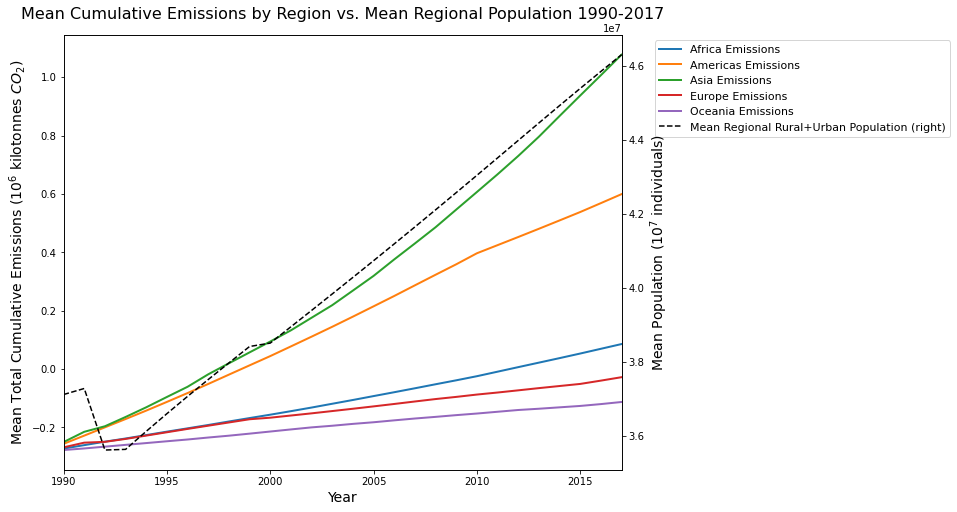

In [106]:
# now plotting!

# created a fontsize variable and a color dictionary to match the colors of other EDA
fs=14
clrs={'Africa':'#1f77b4', 'Americas':'#ff7f0e', 'Asia':'#2ca02c', 'Europe':'#d62728', 'Oceania':'#9467bd'}

# setting up the plot
fig, ax = plt.subplots(figsize=(10,8))

# plotting the emission curves for each region
# group pop_eda by region and then for each region,
# plot cummulative total emission and loop through the colors dict
for key, data in pop_eda.groupby('region'):
    ax = data.plot(x='year', y='cum_sum_total_emission', ax=ax, label=key+" Emissions", color=clrs[key],
                  linewidth=2)

# now on secondary axis plot population curve
ax2 = pop_eda1.plot(x='year', y='total_population', secondary_y=True, ax=ax, 
                    label='Mean Regional Rural+Urban Population', color='black', style="--")


# add extra bits
ax.set_xlabel('Year', fontsize=fs)
ax2.set_ylabel(r'Mean Population ($10^7$ individuals)', fontsize=fs)
ax.set_ylabel(r'Mean Total Cumulative Emissions ($10^6$ kilotonnes $CO_2$)', fontsize=fs)

# the legend was not working properly so I did a sort of manual one
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.05, 1), fontsize=fs-3)

# set xlims and title
ax.set_xlim(1990, 2017)
ax.set_title("Mean Cumulative Emissions by Region vs. Mean Regional Population 1990-2017", fontsize = fs+2,
            pad=16)

# saving and showing
plt.savefig('Population_TotalEmissions', dpi=200, bbox_inches='tight')
plt.show()